In [27]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.wcs import WCS
import matplotlib.cm as cm
import re

In [28]:
def load_curves_and_preds(name_run):

    curvas = np.load(f"../resultados/{name_run}\curvas.npy", allow_pickle=True).item()

    results = np.load(f"../resultados/{name_run}/test_results.npz")
    preds = torch.tensor(results["preds"])
    targets = torch.tensor(results["targets"])
    mean_preds = torch.tensor(results["mean_preds"])
    original_target = torch.tensor(results["original_target"])

    return curvas, preds, targets, mean_preds, original_target

### Functions

In [29]:
def curves_comparisson(resultados, experiments):
    """
    Muestra dos subplots: uno con curvas de entrenamiento y otro con curvas de validación
    para un subconjunto de experimentos en el diccionario `resultados`.

    Args:
        resultados (dict): Diccionario donde cada key es el nombre del experimento y cada valor es
                           una tupla (curvas, preds, targets).
        experiments (list of str): Lista de keys dentro de `resultados` que se desean graficar.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    for key in experiments:
        curvas, _, _, _, _ = resultados[key]
        epochs = np.arange(len(curvas["train_loss"])) + 1
        ax1.plot(epochs, curvas["train_loss"], label=key)
        ax2.plot(epochs, curvas["val_loss"], label=key)

    ax1.set_title("Training Loss")
    ax2.set_title("Validation Loss")

    for ax in [ax1, ax2]:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()

    plt.tight_layout()
    plt.show()

In [30]:
def get_mse_df_from_resultados(resultados):
    """
    Calcula el MSE por transformación para cada experimento del diccionario `resultados`.

    Args:
        resultados (dict): Diccionario donde cada valor es una tupla (curvas, preds, targets).

    Returns:
        pd.DataFrame: DataFrame con los experimentos como filas y los MSE por transformación como columnas.
    """
    mse = torch.nn.MSELoss()
    
    transformations = {
        0: "Original",
        1: "Rotation 90°",
        2: "Rotation 180°",
        3: "Rotation 270°",
        4: "Horizontal Flip",
        5: "HF + Rot 90°",
        6: "HF + Rot 180°",
        7: "HF + Rot 270°",
    }

    data = []

    for name, (_, preds, targets,_,_) in resultados.items():
        row = {}
        for pos, trans_name in transformations.items():
            row[trans_name] = mse(targets[:, pos, :], preds[:, pos, :]).item()
        row["Experimento"] = name
        data.append(row)

    df = pd.DataFrame(data)
    df = df.set_index("Experimento")
    return df

In [31]:
def get_distances(mean_pred,target):

    residual_dist_pix = torch.norm(mean_pred - target, dim=1)    
    host_dist_pix = torch.norm(target, dim=1)   

    return residual_dist_pix, host_dist_pix

In [32]:
def plot_residuals_vs_host_dist(resultados, experiments, titles, cmap_name):


    fig, axs = plt.subplots(1, len(experiments), figsize=(4*len(experiments), 4))

    #cmap = cm.get_cmap(cmap_name, len(experiments))
    #colors = [cmap(i) for i in range(len(experiments))]

    n = len(experiments)
    color_vals = np.linspace(0.2, 0.8, n)
    cmap = cm.get_cmap(cmap_name)
    colors = [cmap(v) for v in color_vals]


    for i, key in enumerate(experiments):
        _, _, _, mean_preds, original_target = resultados[key]
        residual_dist_pix, host_dist_pix = get_distances(mean_preds, original_target)

        x = host_dist_pix * 0.25
        y = residual_dist_pix * 0.25

        axs[i].scatter(x, y, color=colors[i], alpha=0.7)
        axs[i].set_xlim(-3, 65)
        axs[i].set_ylim(-3, 65)
        axs[i].plot([0, 60], [0, 60], linestyle='--', color='gray')

        axs[i].set_xlabel("Host Dist ['']")
        axs[i].set_aspect('equal')
        axs[i].text(5, 55, titles[i], color=colors[i], fontsize=12)

        # Quitar ejes Y de todos excepto el primero
        if i != 0:
            axs[i].set_yticklabels([])
            #axs[i].set_ylabel('')
            #axs[i].tick_params(axis='y', left=False)
            
    axs[0].set_ylabel("Residual Dist ['']")

    plt.tight_layout()
    plt.show()

In [33]:
def obtain_predicted_ra_dec(df_test, resultados, experiment_name):

    def get_wcs(ra, dec):
        wcs = WCS(naxis=2)
        wcs.wcs.crpix = [15.0, 15.0]
        wcs.wcs.cdelt = [-6.944444445183e-5, 6.944444445183e-5]  # grados/píxel
        wcs.wcs.crval = [ra, dec]
        wcs.wcs.ctype = ["RA---TAN", "DEC--TAN"]
        wcs.wcs.cunit = ["deg", "deg"]
        return wcs

    _, _, _, mean_preds, _ = resultados[experiment_name]

    coordinates = []
    for idx in range(len(df_test)):
    
        match = re.search(r'\(([-+]?(?:\d*\.\d+|\d+\.?)),\s*([-+]?(?:\d*\.\d+|\d+\.?))\)', df_test.iloc[idx]["sn_coords"])
        ra = np.float64(match.group(1))
        dec = np.float64(match.group(2))

        wcs = get_wcs(ra, dec)

        ra_host, dec_host = wcs.pixel_to_world_values([mean_preds[idx] +14])[0] # pred = (x,y) = (dec, ra)

        coordinates.append([ra_host, dec_host])
    
    return np.array(coordinates)


### Curves

In [35]:
resultados = {
              "Baseline Sersic OIDS": load_curves_and_preds("delight_baseline_sersic_oids"),
              "Augmented dataset[x30] BS 512 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids"),
              "Augmented dataset[x30] balanced 10-50 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_10_50"),
              "Augmented dataset[x30] balanced 05-50 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_05_50"),
              "Augmented dataset[x30] balanced 05-50 BS256 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_05_50_bs256"),
              "Augmented dataset[x30] balanced 05-30 BS256 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_05_30_bs256"),
              "Augmented dataset[x30] balanced log 01-50 BS256 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_log_01_50_bs256"),

              }

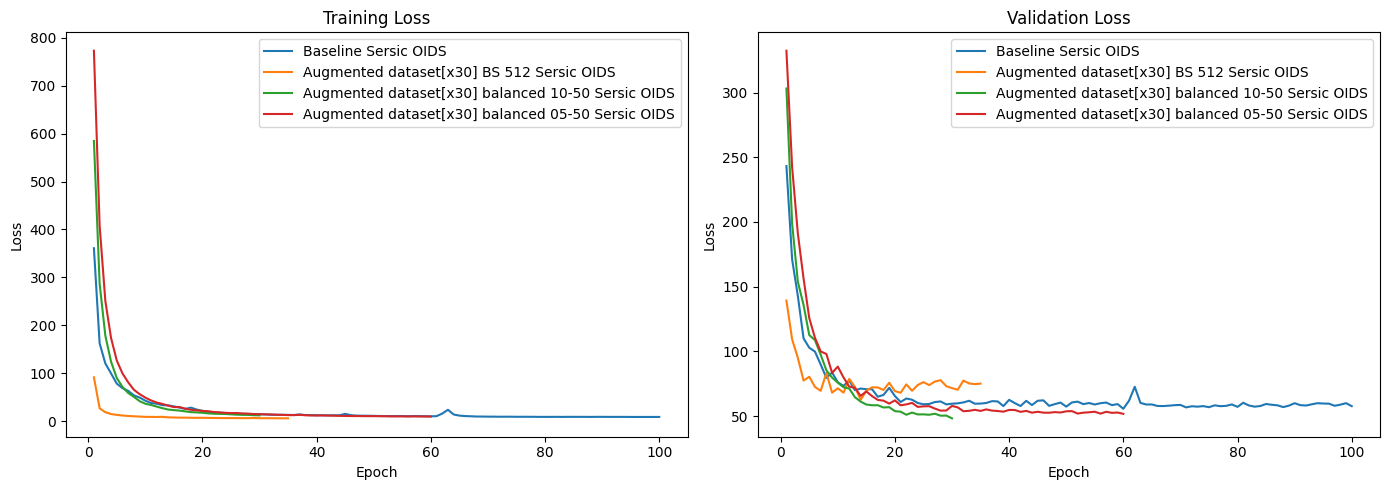

In [22]:
curves_comparisson(resultados, experiments=["Baseline Sersic OIDS",
                                            "Augmented dataset[x30] BS 512 Sersic OIDS",
                                            "Augmented dataset[x30] balanced 10-50 Sersic OIDS",
                                            "Augmented dataset[x30] balanced 05-50 Sersic OIDS"])

### Metrics

In [23]:
df_metrics = get_mse_df_from_resultados(resultados)
df_metrics

,Original,Rotation 90°,Rotation 180°,Rotation 270°,Horizontal Flip,HF + Rot 90°,HF + Rot 180°,HF + Rot 270°
Experimento,,,,,,,,
Baseline Sersic OIDS,81.048462,83.375816,81.453506,76.548859,76.377258,83.778770,83.503319,81.006302
Augmented dataset[x30] BS 512 Sersic OIDS,90.527588,91.977837,90.195831,92.526314,90.360580,90.263779,93.863731,92.202507
Augmented dataset[x30] balanced 10-50 Sersic OIDS,80.416161,75.516380,79.249481,82.080948,79.819626,77.449677,77.626289,80.781670
Augmented dataset[x30] balanced 05-50 Sersic OIDS,80.221069,75.780434,79.993294,87.811226,78.467712,82.832123,79.474190,80.548485
Augmented dataset[x30] balanced 05-50 BS256 Sersic OIDS,83.112953,71.723106,80.996254,77.978569,76.702278,80.763809,77.517273,79.367348
Augmented dataset[x30] balanced 05-30 BS256 Sersic OIDS,77.409027,75.008102,77.676193,75.043335,73.483986,74.424408,77.206177,77.766304


In [37]:
resultados = {
              "Baseline Sersic OIDS": load_curves_and_preds("delight_baseline_sersic_oids"),
              "Augmented dataset[x30] BS 512 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids"),
              "Augmented dataset[x30] balanced 10-50 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_10_50"),
              "Augmented dataset[x30] balanced 05-50 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_05_50"),
              "Augmented dataset[x30] balanced 05-50 BS256 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_05_50_bs256"),
              "Augmented dataset[x30] balanced 05-30 BS256 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_05_30_bs256"),
              "Augmented dataset[x30] balanced log 01-50 BS256 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_log_01_50_bs256"),
              "Augmented dataset[x30] balanced log 01-50 Sersic OIDS": load_curves_and_preds("delight_augmented_x30_sersic_oids_balanced_log_01_50"),

              }

C:\Users\Legers\AppData\Local\Temp\ipykernel_11076\1875932723.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


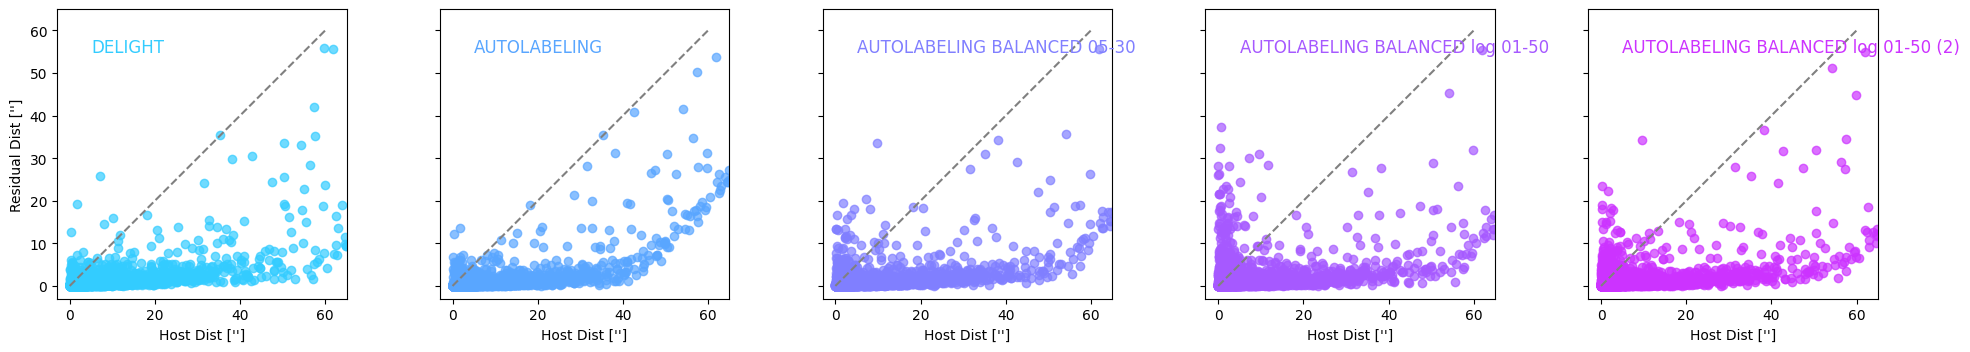

In [38]:
plot_residuals_vs_host_dist(resultados, experiments=["Baseline Sersic OIDS",
                                                    "Augmented dataset[x30] BS 512 Sersic OIDS",
                                                    "Augmented dataset[x30] balanced 05-30 BS256 Sersic OIDS",
                                                    "Augmented dataset[x30] balanced log 01-50 BS256 Sersic OIDS",
                                                    "Augmented dataset[x30] balanced log 01-50 Sersic OIDS"],

                                        titles = ["DELIGHT", "AUTOLABELING", "AUTOLABELING BALANCED 05-30", "AUTOLABELING BALANCED log 01-50", "AUTOLABELING BALANCED log 01-50 (2)"],
                                        cmap_name ="cool")

C:\Users\Legers\AppData\Local\Temp\ipykernel_11076\1875932723.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)


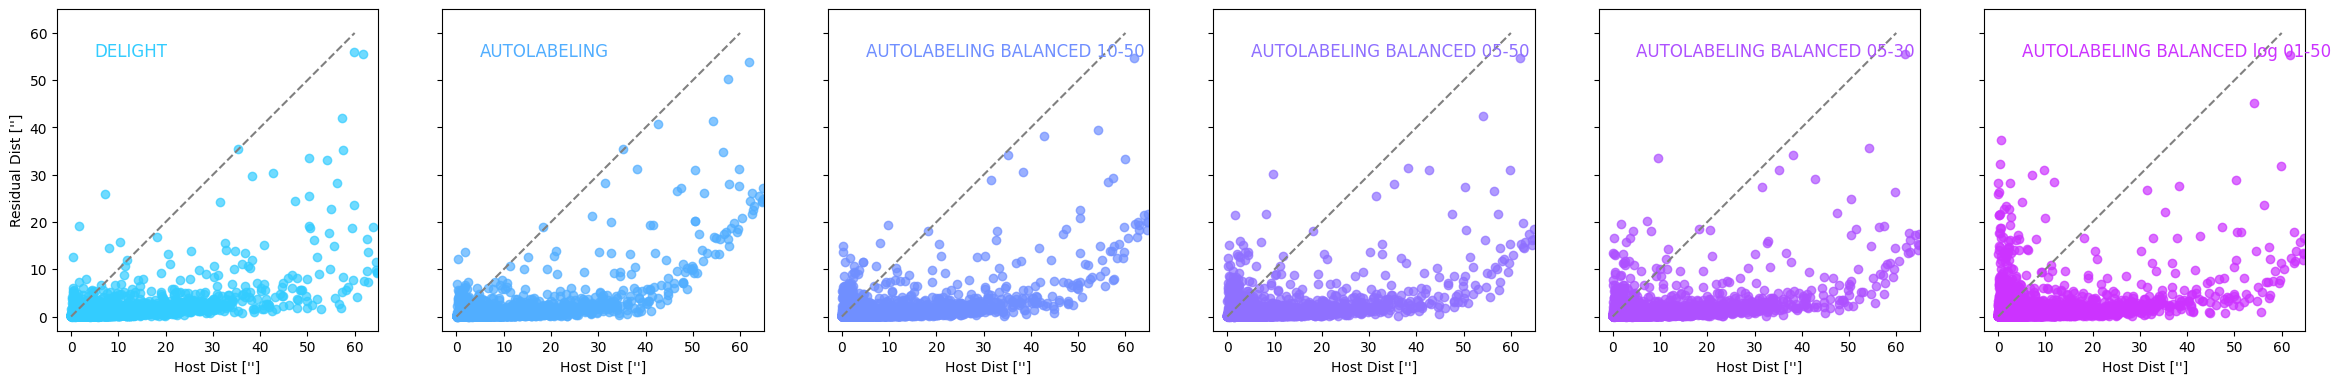

In [36]:
plot_residuals_vs_host_dist(resultados, experiments=["Baseline Sersic OIDS",
                                                    "Augmented dataset[x30] BS 512 Sersic OIDS",
                                                    "Augmented dataset[x30] balanced 10-50 Sersic OIDS",
                                                    "Augmented dataset[x30] balanced 05-50 BS256 Sersic OIDS",
                                                    "Augmented dataset[x30] balanced 05-30 BS256 Sersic OIDS",
                                                    "Augmented dataset[x30] balanced log 01-50 BS256 Sersic OIDS"],

                                        titles = ["DELIGHT", "AUTOLABELING", "AUTOLABELING BALANCED 10-50", "AUTOLABELING BALANCED 05-50", "AUTOLABELING BALANCED 05-30", "AUTOLABELING BALANCED log 01-50"],
                                        cmap_name ="cool")

In [59]:
images = np.load("..\data\SERSIC\dataset_multires_30_simple_method.npy")                                # Imagenes multi-resolucion original
df = pd.read_csv("..\data\SERSIC\df.csv", dtype={'objID': 'Int64'})    # Dataframe con metadata de Sersic 

sn_pos = df[["dx","dy"]].values.astype(np.float32)


oid_test = np.load(f"..\data\SERSIC\id_test.npy",allow_pickle=True)
idx_test = df[df['oid'].isin(oid_test)].index.to_numpy()

df_test = df.iloc[idx_test]
X_test = images[idx_test]
y_test = sn_pos[idx_test]

_, preds, targets = resultados["Augmented dataset[x30] BS 512 Sersic OIDS"]
preds_autolabeling, _, _, _ = get_metrics(preds, targets)

_, preds, targets = resultados["Baseline Sersic OIDS"]
preds_baseline, _, _, _ = get_metrics(preds, targets)

In [44]:
real_coords = pd.read_csv("..\data\SERSIC\df_test_host_coordinates.csv")
autolabeling_coords = pd.read_csv("..\data\SERSIC\df_preds_autolabeling.csv")

In [ ]:
real_coords[mask_final].iloc[11]
358.424625 16.229833

ra     358.424625
dec     16.229833
Name: 880, dtype: float64

In [ ]:
autolabeling_coords[mask_final].iloc[11]
358.424742 16.229828

ra     358.424742
dec     16.229828
Name: 880, dtype: float64

In [23]:
df_oids_preds_autolabeling = pd.read_csv("..\data\SERSIC/autolabeling_objID.csv", dtype={'objID': 'Int64'})["objID"]
df_oids_preds_baseline = pd.read_csv("..\data\SERSIC/baseline_objID.csv", dtype={'objID': 'Int64'})["objID"]

df_oids_real = pd.read_csv("..\data\SERSIC/real_objID.csv", dtype={'objID': 'Int64'})["objID"]

In [24]:
mask_nan_autolabeling = (df_oids_real.isna().values) + (df_oids_preds_autolabeling.isna().values)
mask_nan_baseline = (df_oids_real.isna().values) + (df_oids_preds_baseline.isna().values)

In [71]:
df_oids_real.isna().values.sum()

1592

In [26]:
preds_oids_autolabeling = (df_oids_real == df_oids_preds_autolabeling)
preds_oids_baseline = (df_oids_real == df_oids_preds_baseline)

In [27]:
acc_autolabeling  = preds_oids_autolabeling[~mask_nan_autolabeling].sum()/len(preds_oids_autolabeling[~mask_nan_autolabeling])
acc_baseline  = preds_oids_baseline[~mask_nan_baseline].sum()/len(preds_oids_baseline[~mask_nan_baseline])

In [28]:
mask_bad_prediction = ((~preds_oids_autolabeling) & (~preds_oids_baseline))

In [81]:
(~(preds_oids_autolabeling[~mask_nan_autolabeling])).sum()

41

In [29]:
print(len(preds_oids_autolabeling))
print(len(preds_oids_baseline))

4788
4788


In [30]:
print(preds_oids_autolabeling.sum())
print(preds_oids_baseline.sum())

3097
3091


In [31]:
print(acc_autolabeling)
print(acc_baseline)

0.9869343530911409
0.9872245289045034


In [79]:
3097*(1-0.98693)

40.477790000000084

In [56]:
mask_bad_prediction = (~(preds_oids_autolabeling & preds_oids_baseline))
mask_nan = mask_bad_prediction.isna()

mask_final = mask_bad_prediction & (~mask_nan)

In [60]:
X_problem = X_test[mask_final]
y_problem = y_test[mask_final]
y_preds_problem_auto = preds_autolabeling[mask_final]
y_preds_problem_base = preds_baseline[mask_final]

C:\Users\Legers\AppData\Local\Temp\ipykernel_15016\1173653258.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  y_preds_problem_auto = preds_autolabeling[mask_final]
C:\Users\Legers\AppData\Local\Temp\ipykernel_15016\1173653258.py:4: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  y_preds_problem_base = preds_baseline[mask_final]


C:\Users\Legers\AppData\Local\Temp\ipykernel_15016\2229704363.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[4].legend()


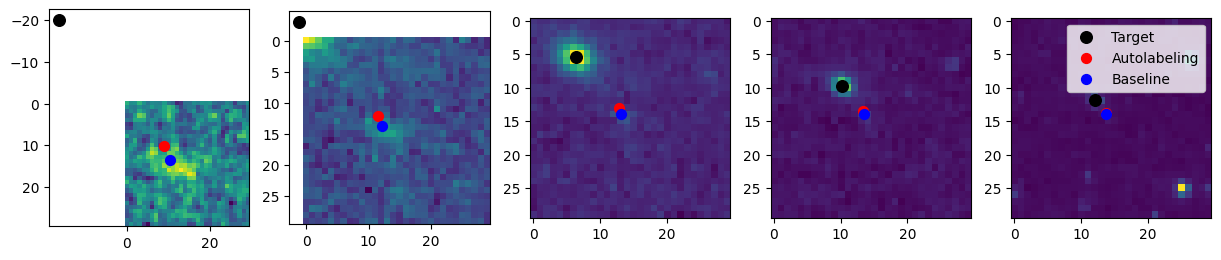

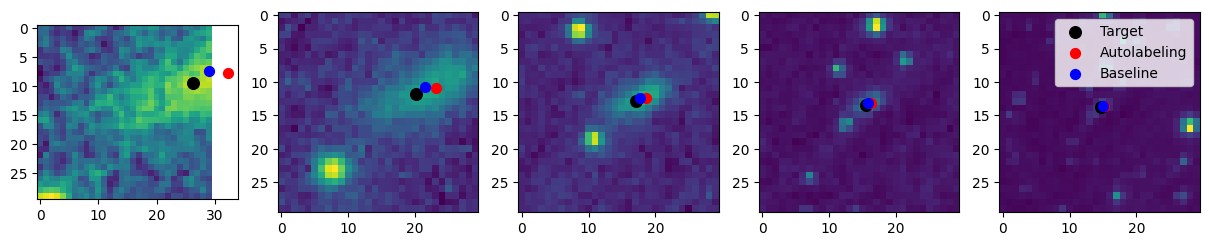

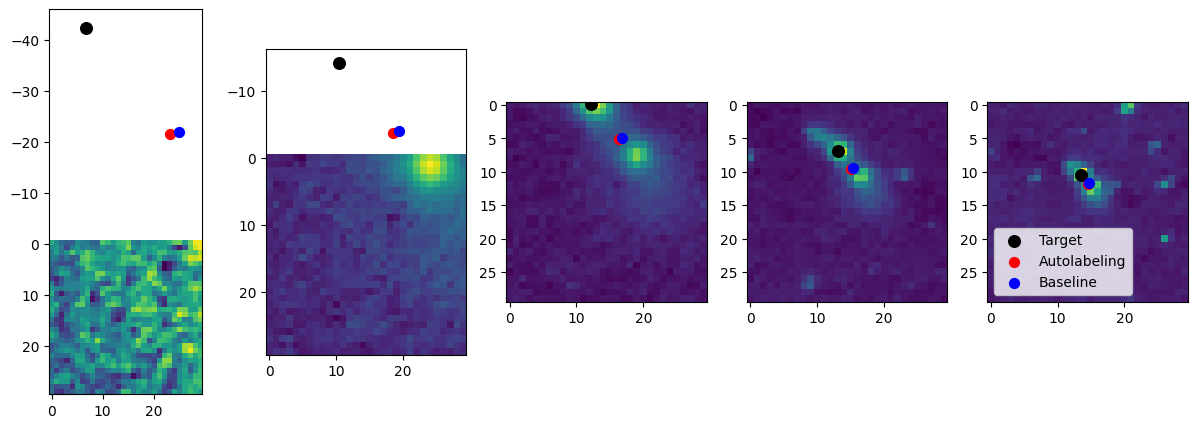

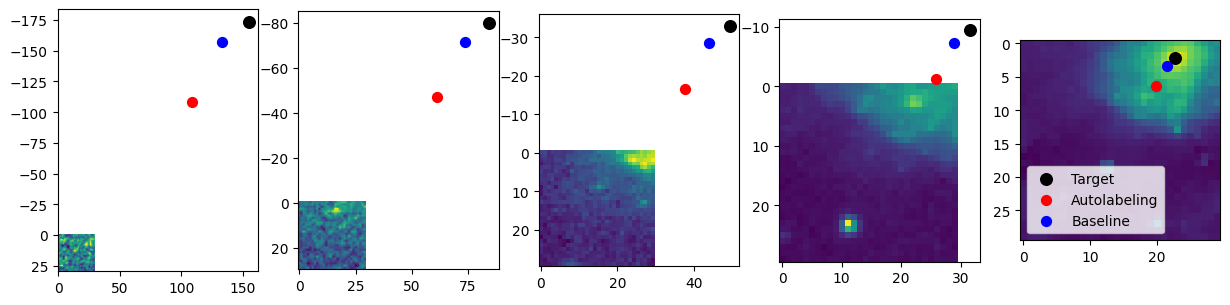

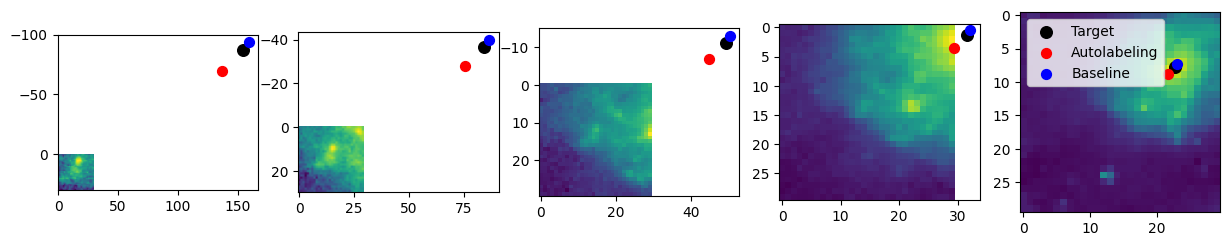

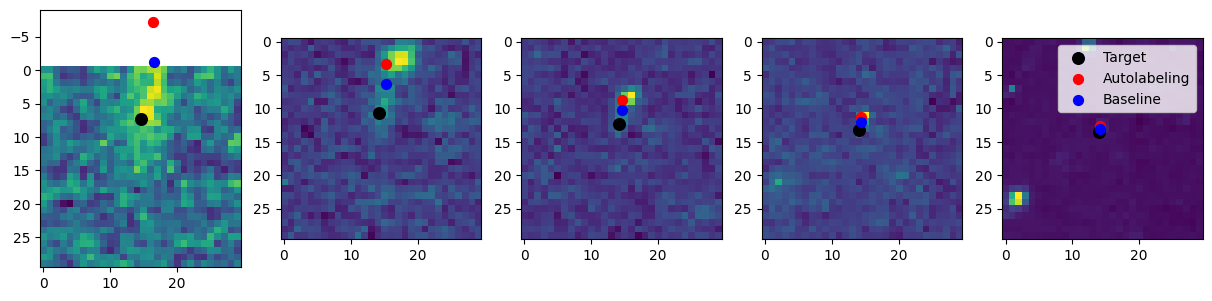

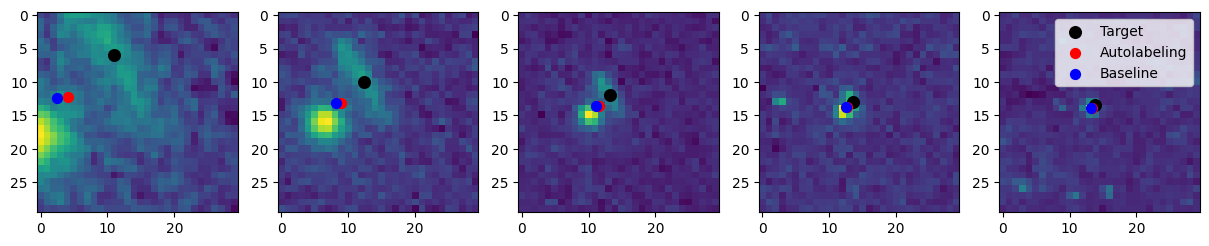

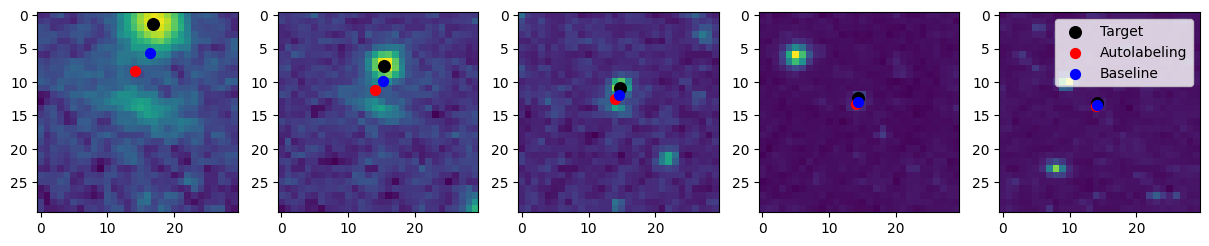

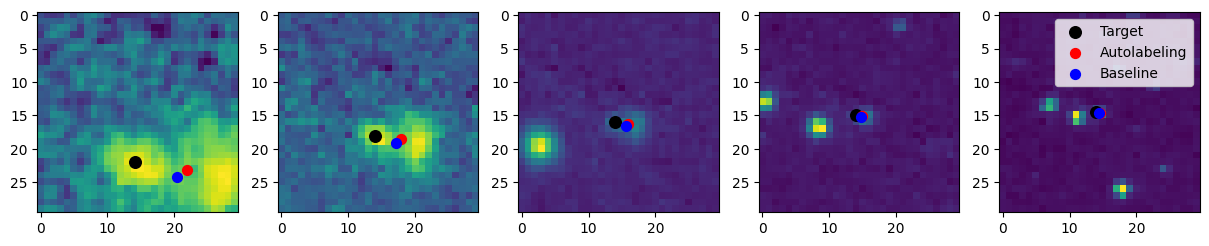

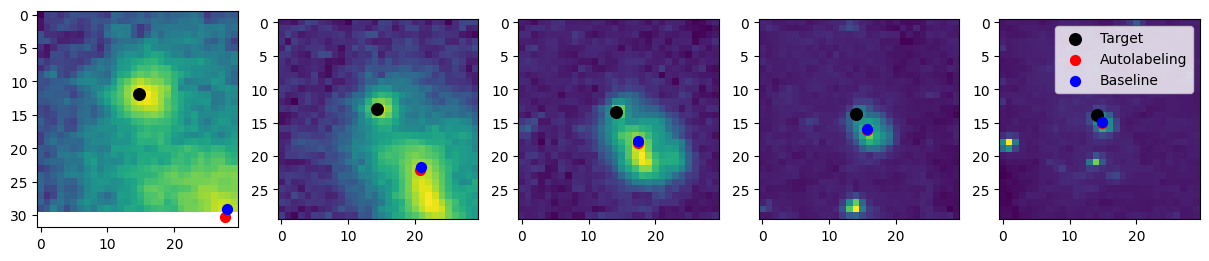

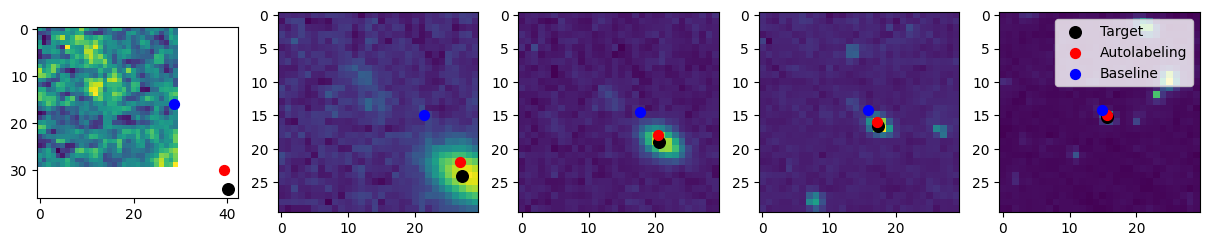

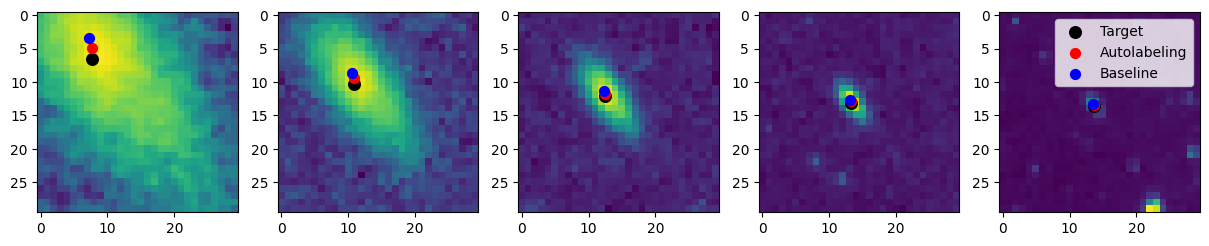

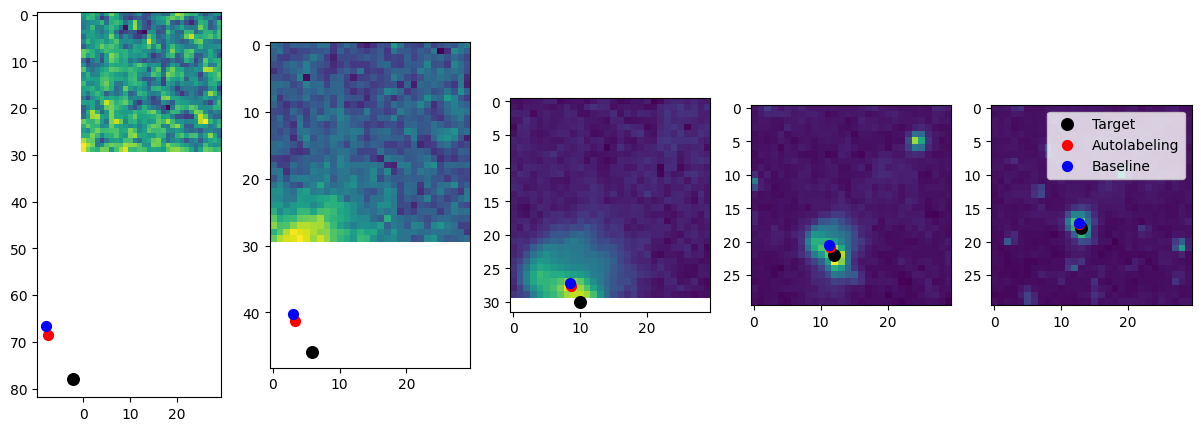

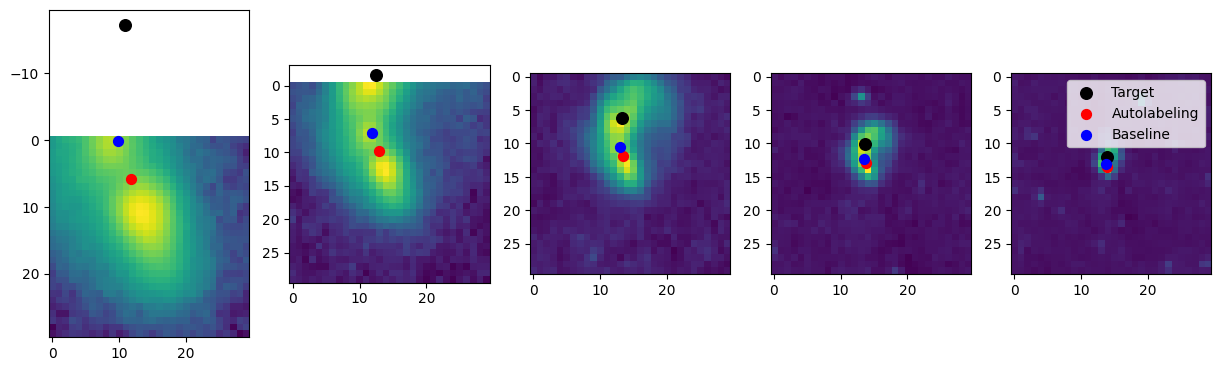

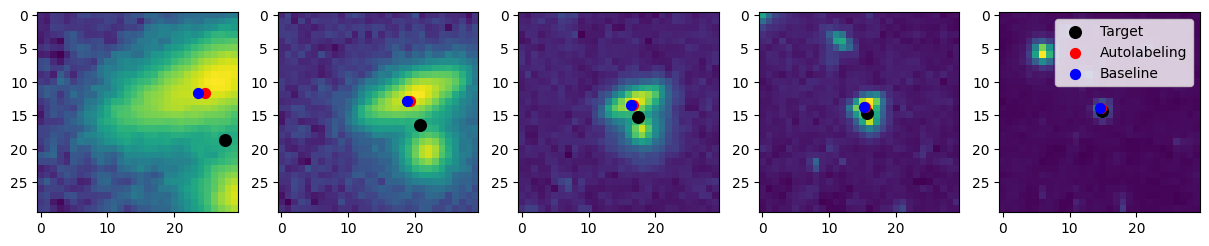

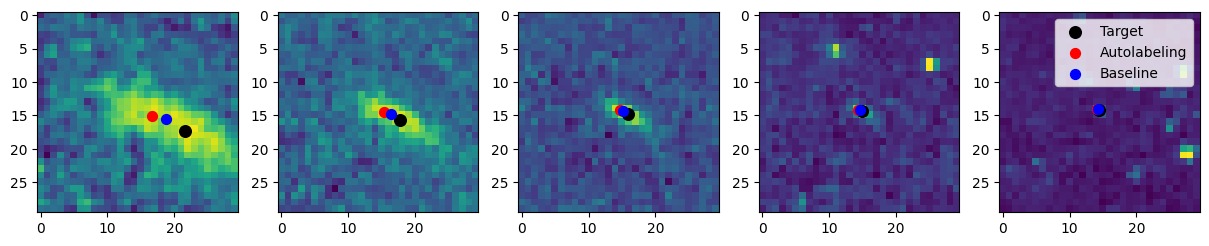

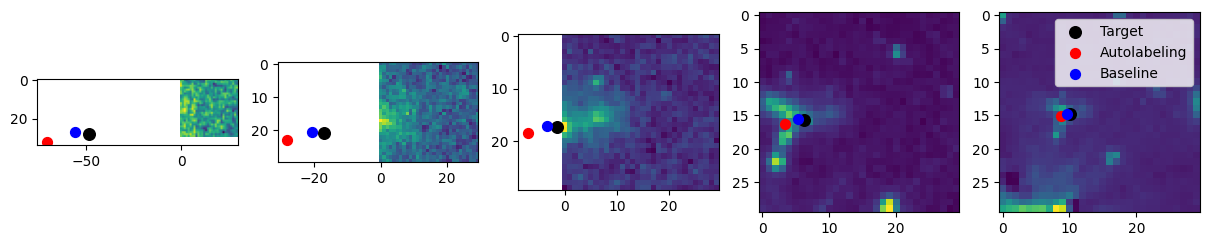

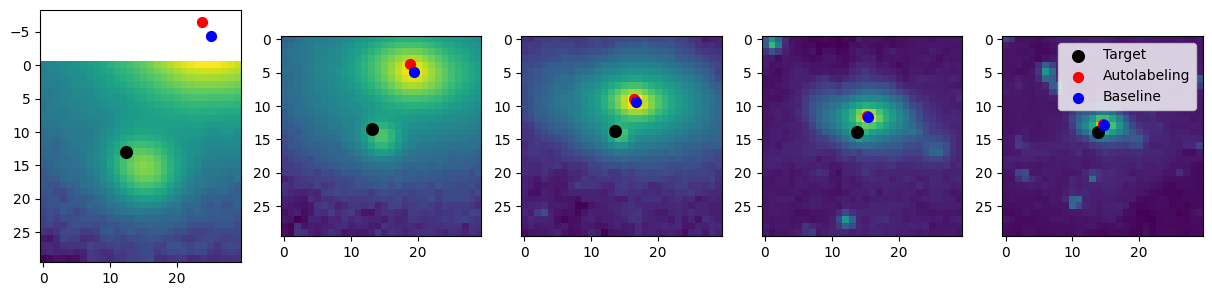

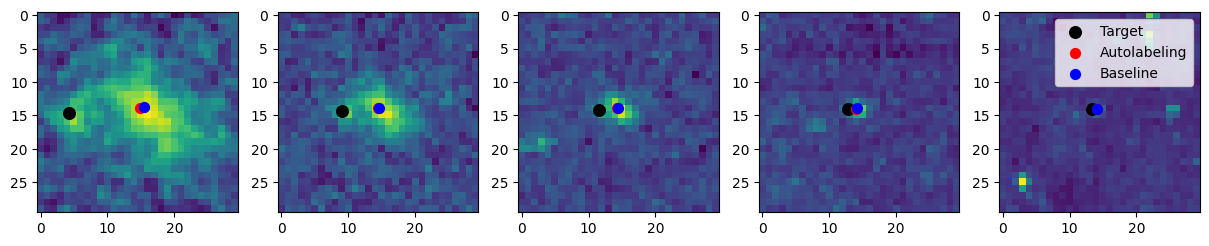

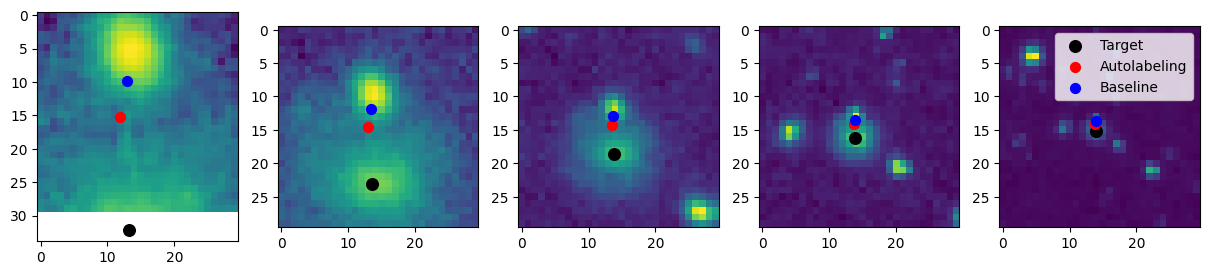

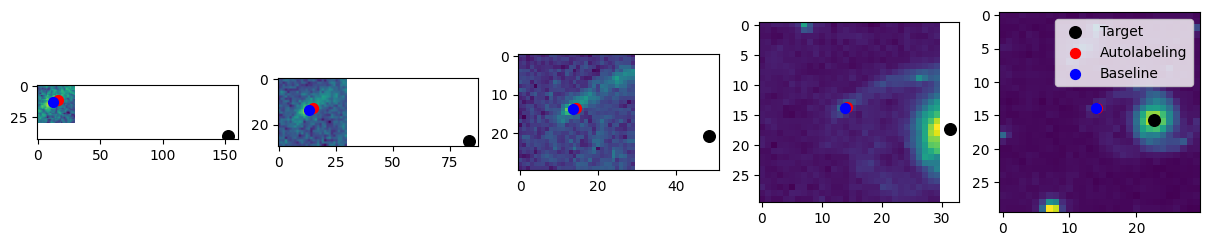

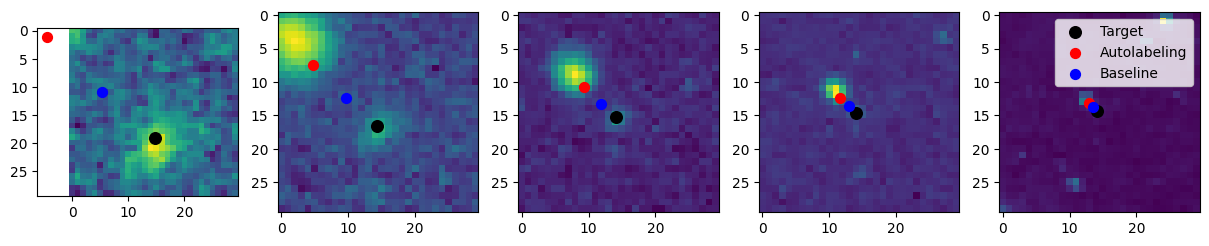

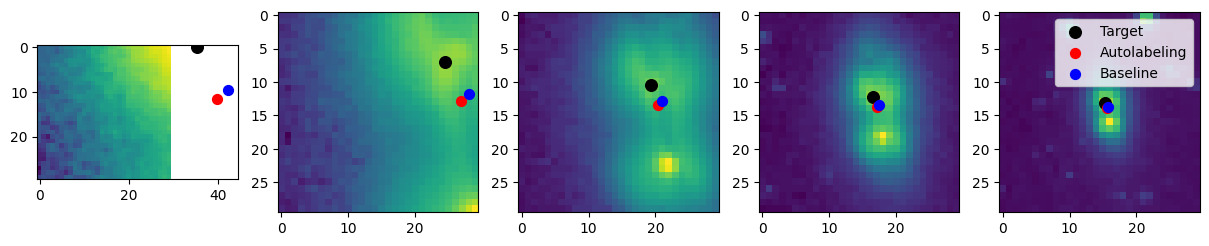

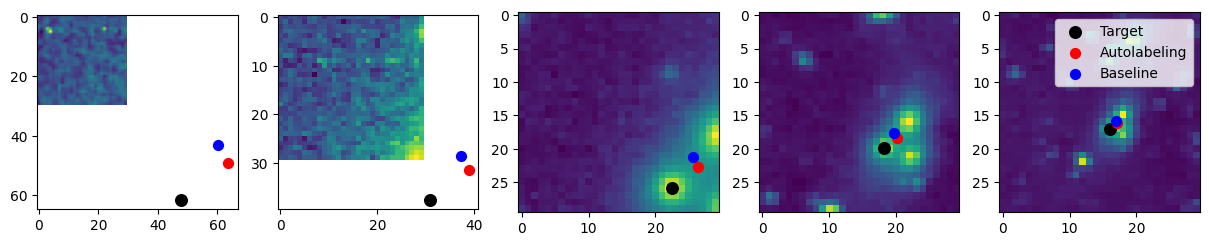

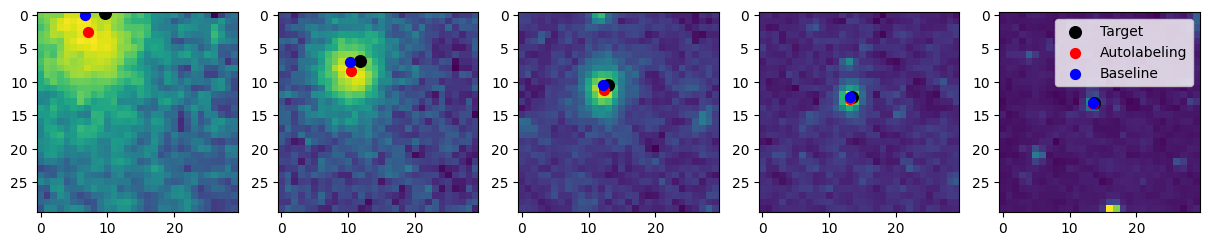

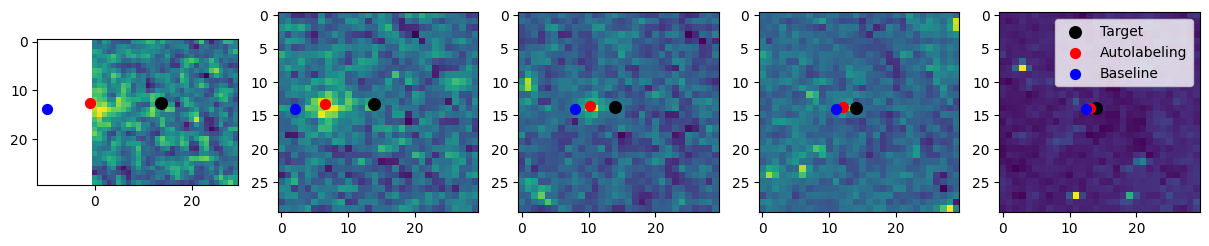

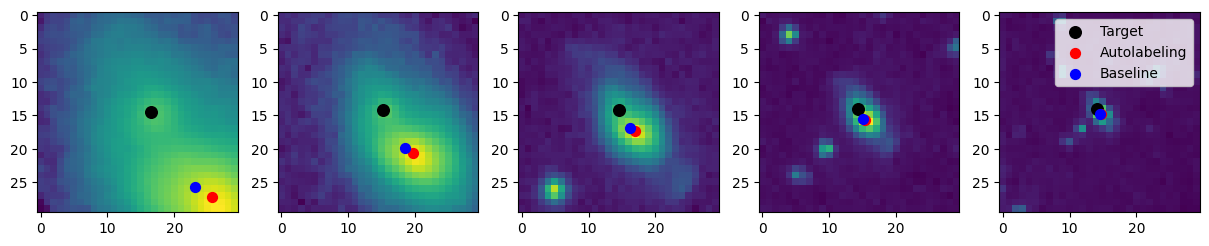

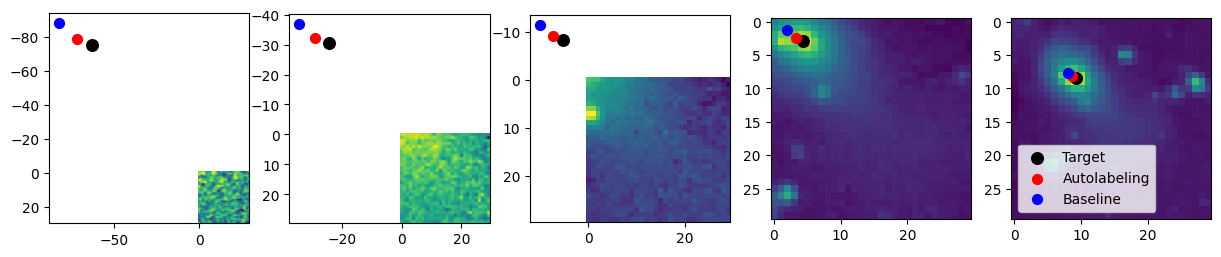

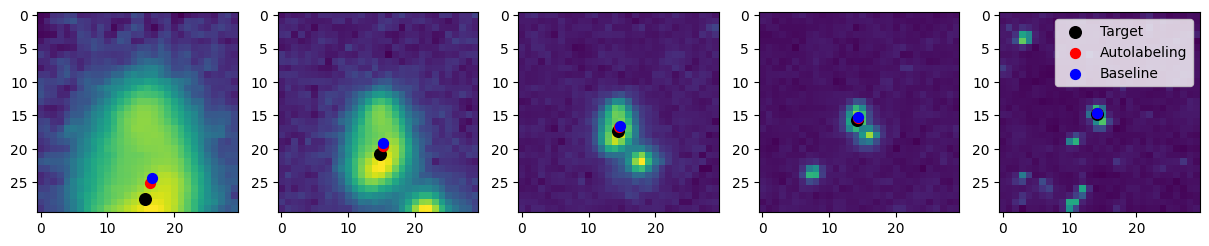

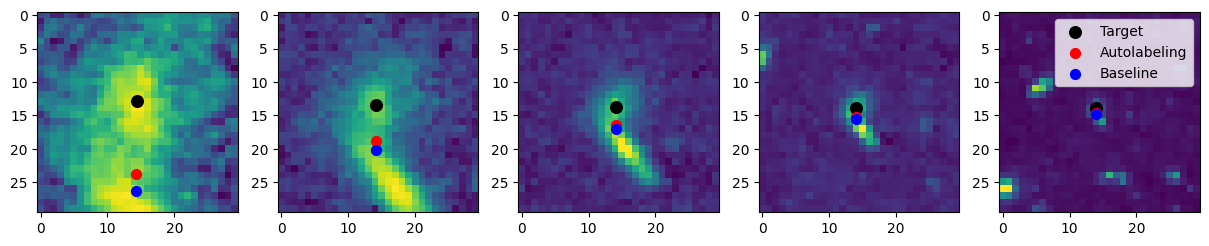

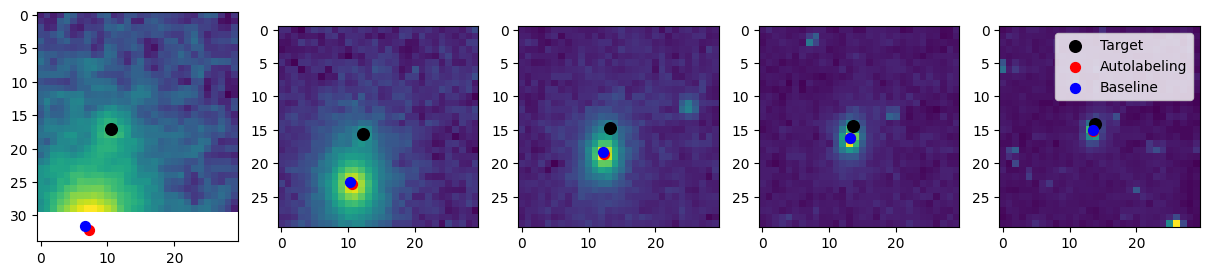

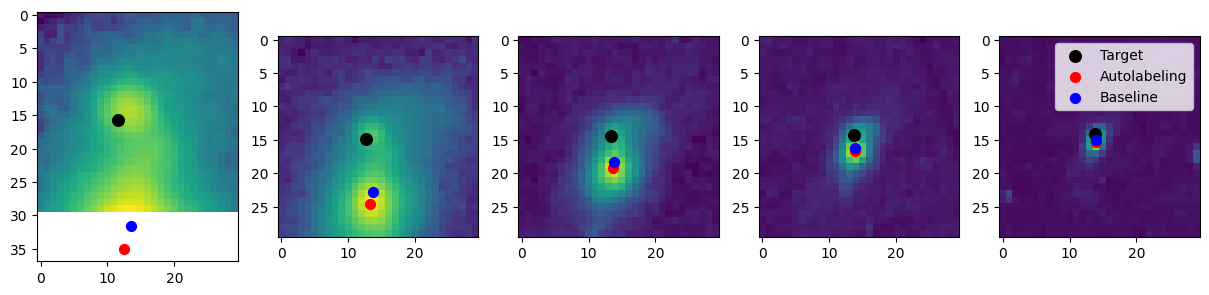

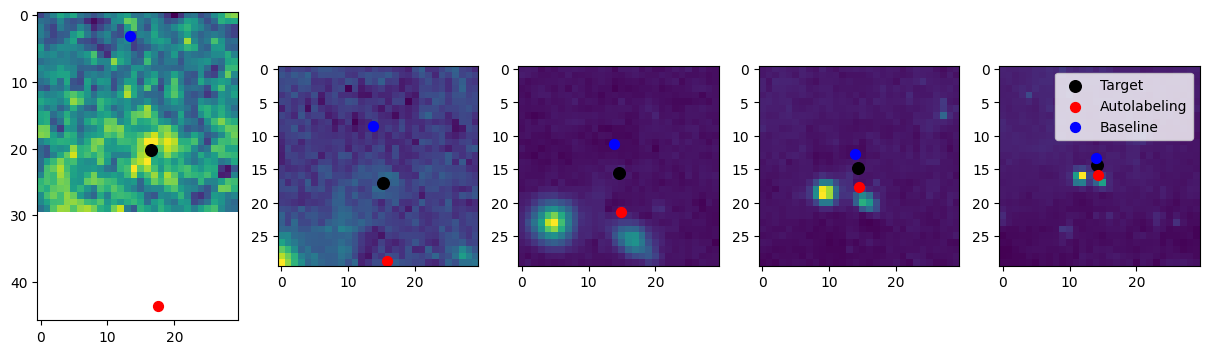

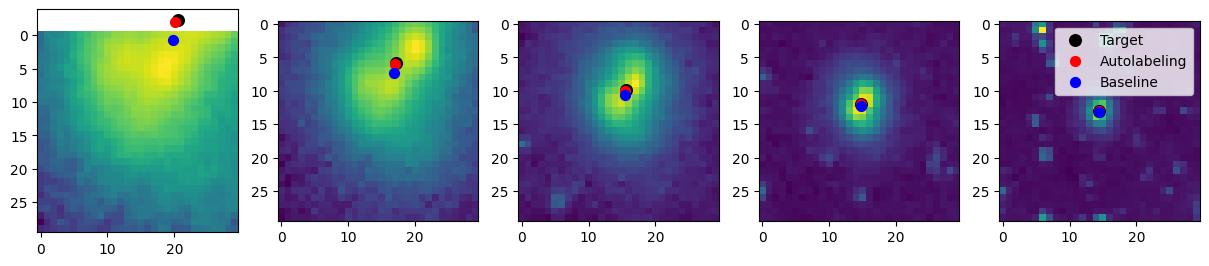

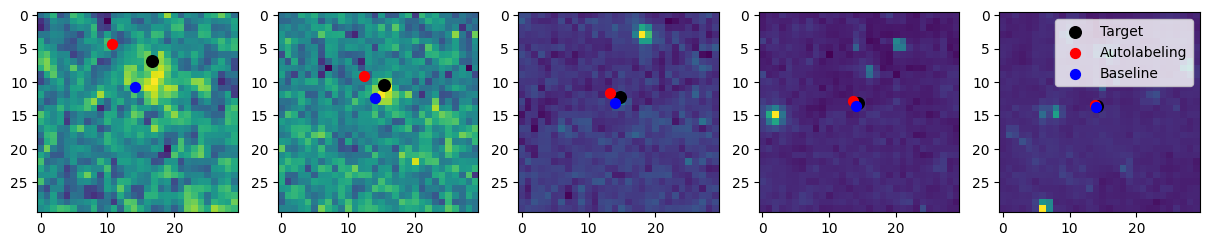

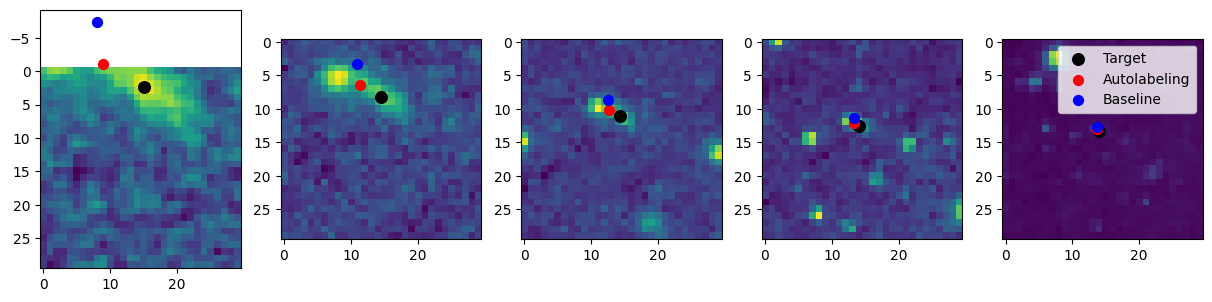

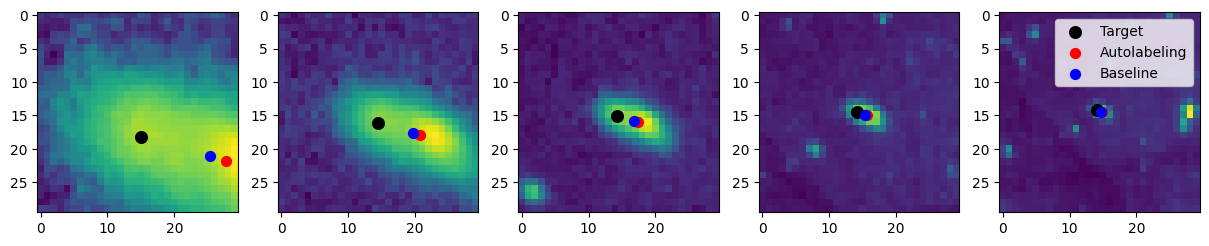

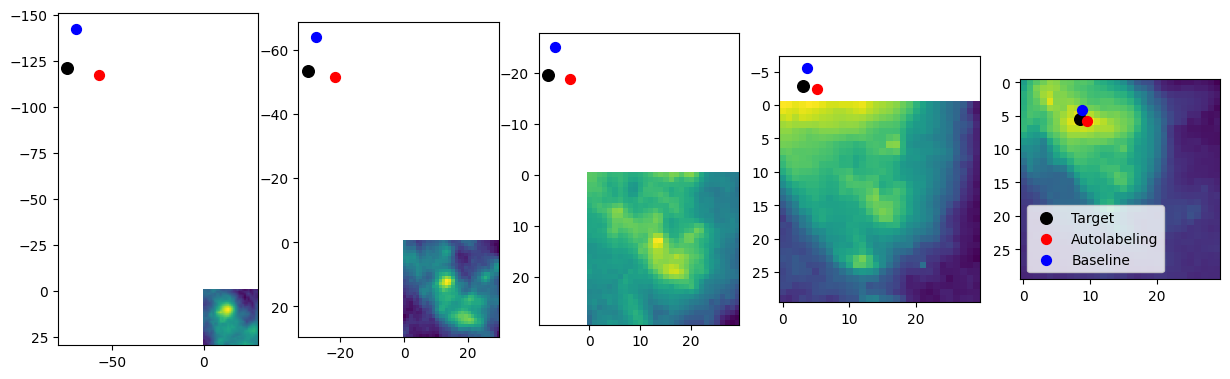

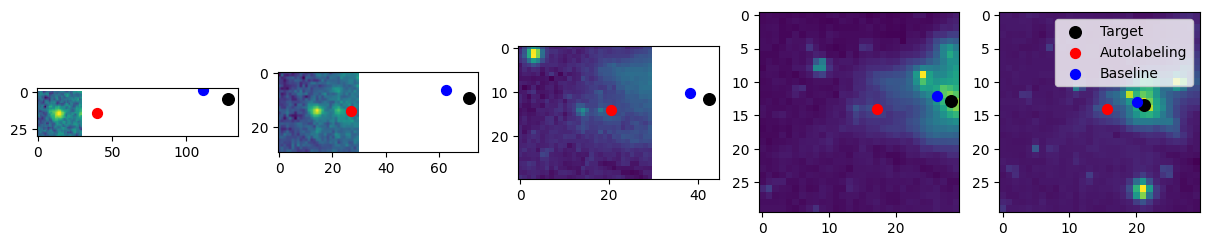

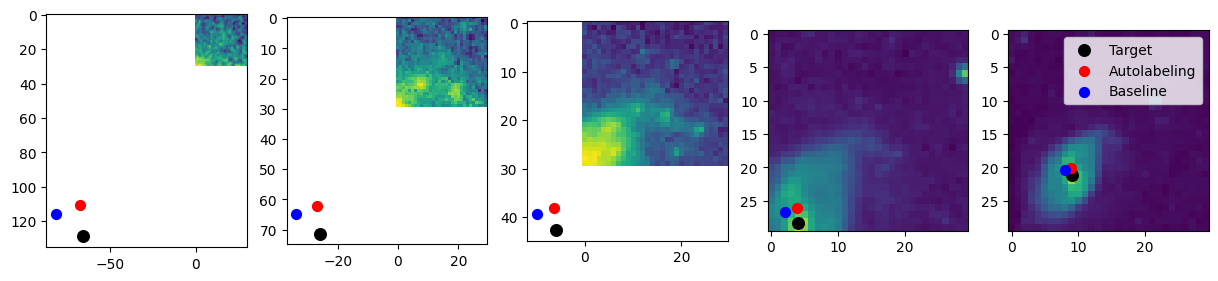

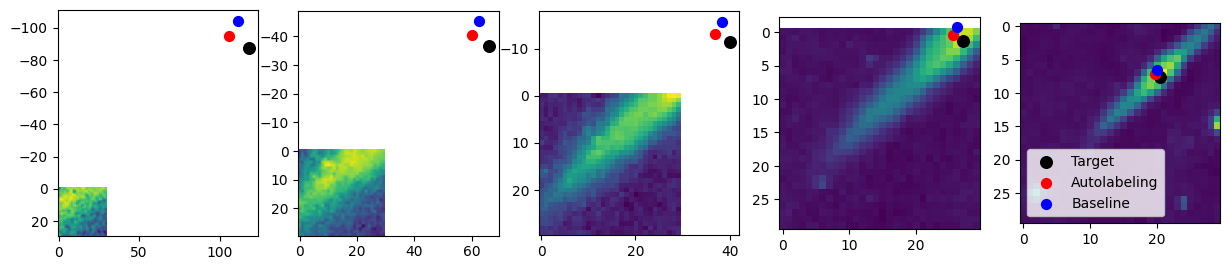

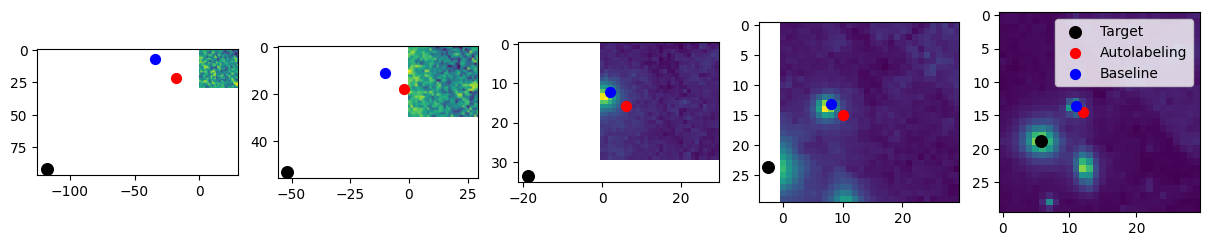

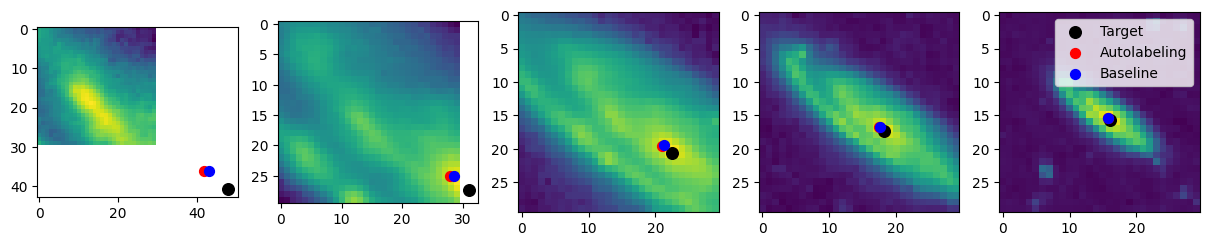

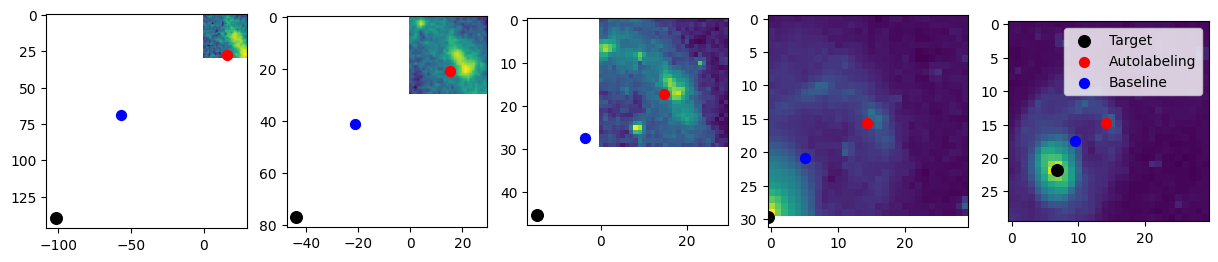

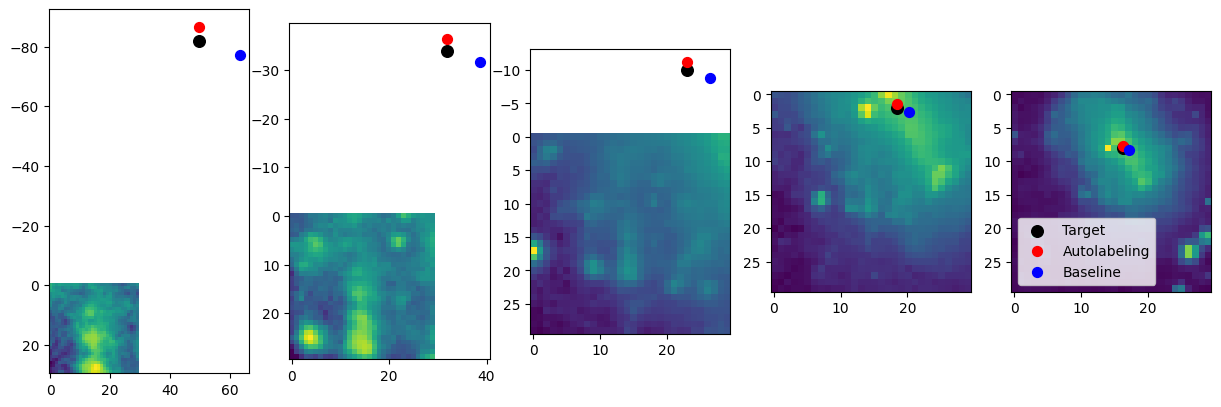

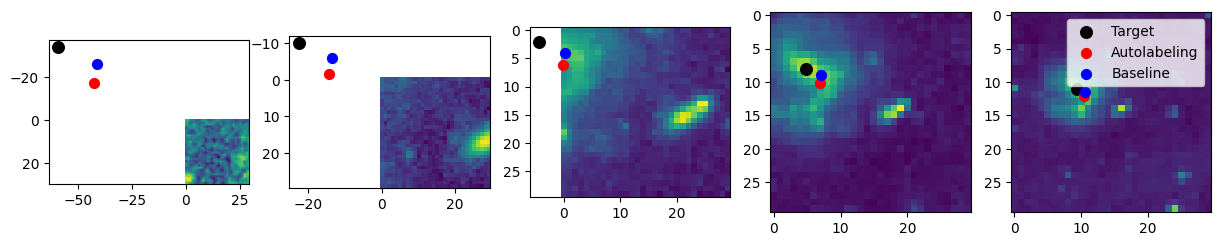

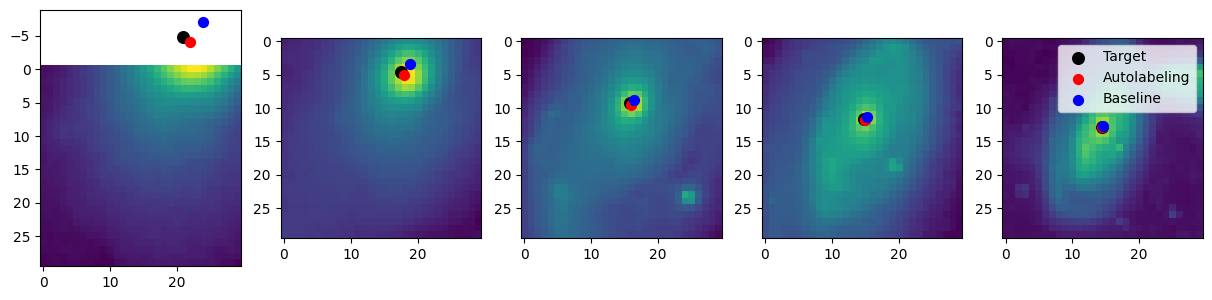

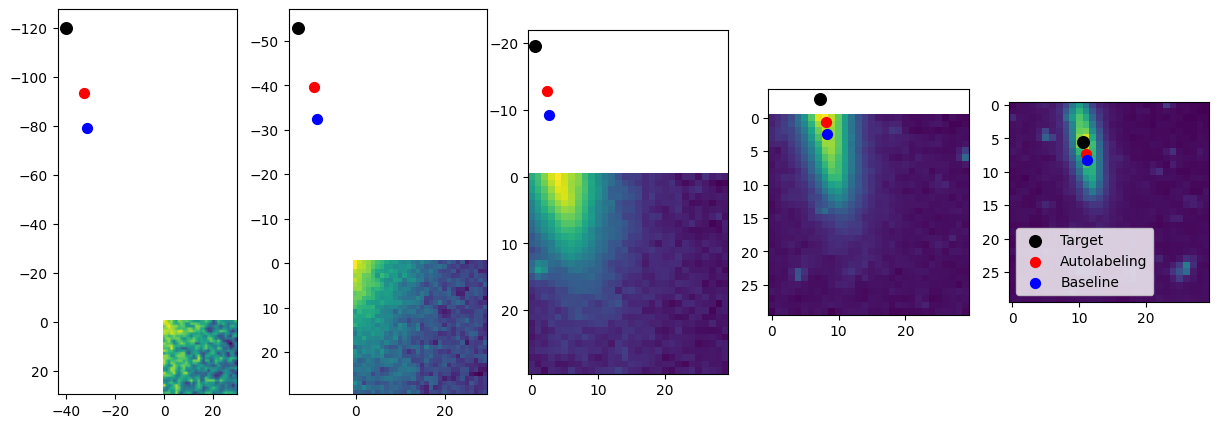

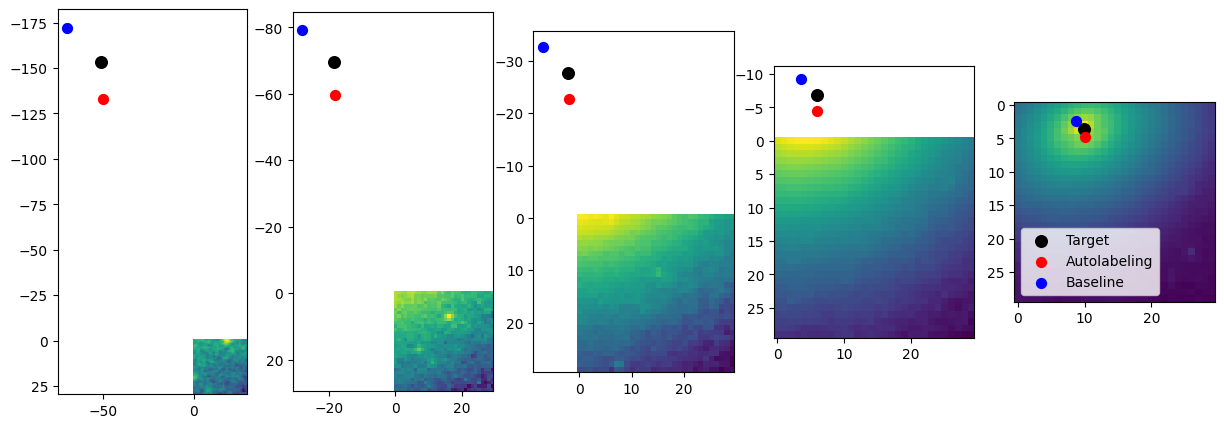

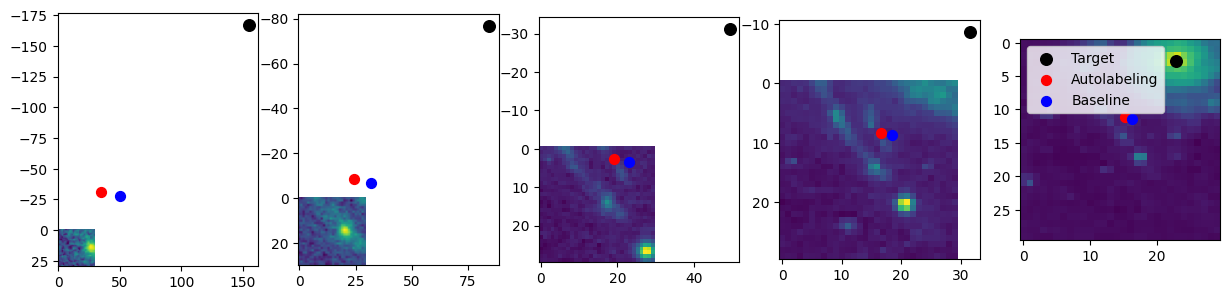

In [69]:
for idx in range(50):

    fig, axs = plt.subplots(1,5, figsize=(15,5))

    for m in range(5):
        axs[m].imshow(X_problem[idx,:,:,m])
        axs[m].scatter((y_problem[idx,1]/(2**m) + 14) , (y_problem[idx,0]/(2**m)+ 14), s=70, color="black", label="Target")
        axs[m].scatter((y_preds_problem_auto[idx,0]/(2**m) + 14) , (y_preds_problem_auto[idx,1]/(2**m)+ 14), s=50, color="red", label="Autolabeling")
        axs[m].scatter((y_preds_problem_base[idx,0]/(2**m) + 14) , (y_preds_problem_base[idx,1]/(2**m)+ 14), s=50, color="Blue", label="Baseline")

        axs[4].legend()

    plt.show()